In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from plotting_constants import gif_length, fps, carrier_colors, nice_names
from plotting_constants import color_dict as cost_factor_colors
from plotting_constants import width_unit, height_unit

In [2]:
carrier_colors['interconnector'] = 'plum'


In [3]:
day = '2024-03-21'
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
    )

bmus = bmus.loc[bmus['lat'] != 'distributed']

bmus['lat'] = bmus['lat'].apply(lambda x: np.around(float(x), 4))
bmus['lon'] = bmus['lon'].apply(lambda x: np.around(float(x), 4))

# bmus


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pypsa

def create_aggregated_timeseries(network, carrier_colors):
    ac_buses = network.buses.index[network.buses.carrier == "AC"]
    gen = network.generators[network.generators.bus.isin(ac_buses)]
    if not gen.empty:
        gen_ts = network.generators_t.p[gen.index]
        gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()

    else:
        gen_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    stor = network.storage_units[network.storage_units.bus.isin(ac_buses)]
    if not stor.empty:
        stor_ts = network.storage_units_t.p[stor.index]
        stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
    else:
        stor_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    links = network.links
    link_contrib = pd.DataFrame(0, index=network.snapshots, columns=links.index)
    for link in links.index:
        bus0 = links.loc[link, "bus0"]
        bus1 = links.loc[link, "bus1"]
        p = network.links_t.p0[link]

        if bus0 in ac_buses and bus1 not in ac_buses:
            link_contrib[link] = -p
        elif bus1 in ac_buses and bus0 not in ac_buses:
            link_contrib[link] = p

    if not links.empty:
        if 'carrier' in links.columns:
            link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
        else:
            link_contrib.columns = ["interconnector"] * len(link_contrib.columns)
            link_contrib_grouped = link_contrib.groupby(axis=1, level=0).sum()
    else:
        link_contrib_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])

    all_carriers = list(set(gen_ts_grouped.columns).union(stor_ts_grouped.columns).union(link_contrib_grouped.columns))

    combined = pd.DataFrame(0, index=network.snapshots, columns=all_carriers)
    for df in [gen_ts_grouped, stor_ts_grouped, link_contrib_grouped]:
        for col in df.columns:
            combined[col] = combined[col] + df[col]

    sorted_cols = [carrier for carrier in carrier_colors.keys() if carrier in combined.columns]
    remaining = [carrier for carrier in combined.columns if carrier not in sorted_cols]

    combined = combined[sorted_cols + remaining].mul(1e-3)

    sort_order = combined.var().sort_values().index
    neg = combined[combined <= 0].replace(np.nan, 0)[sort_order]
    pos = combined[combined > 0].replace(np.nan, 0)[sort_order]

    return pos, neg


def animate_generation_mix(
        network,
        carrier_colors,
        gif_length_sec=10,
        fps=25,
        output_filename="generation_mix.gif"
        ):

    pos, neg = create_aggregated_timeseries(network, carrier_colors)

    x_times = (pos.index - pos.index[0]).total_seconds() / 3600.0
    carriers = pos.columns.tolist()

    y_data_pos = [pos[carrier].values for carrier in carriers]
    y_data_neg = [neg[carrier].values for carrier in carriers]

    fig, ax = plt.subplots(figsize=(2*width_unit, height_unit))

    # ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Power (GW)")
    # ax.set_title("Generation Mix Over a Day")

    colors = [carrier_colors.get(carrier, None) for carrier in carriers]

    stack_kwargs = {
        'linewidth': 0.5,
        'edgecolor': 'black',
        'alpha': 0.9,
    }

    ax.stackplot(x_times, y_data_pos, labels=carriers, colors=colors, **stack_kwargs)
    ax.stackplot(x_times, y_data_neg, labels=carriers, colors=colors, **stack_kwargs)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # ax.legend(loc="upper left")
    ax.set_xlim(0, 23)
    vline = ax.axvline(x=0, color="k", linestyle="-", linewidth=1.5)
    total_frames = int(gif_length_sec * fps)
    x_positions = np.linspace(0, 24, total_frames)

    from matplotlib.ticker import LinearLocator
    ax.xaxis.set_major_locator(LinearLocator(5))

    ax.set_xticks([0, 5.75, 11.5, 17.25, 23])
    ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])

    def update(frame):
        vline.set_xdata([x_positions[frame]])
        return [vline]

    # plt.show()
    # import sys
    # sys.exit()

    

    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True, interval=1000/fps)

    fig.tight_layout()
    ani.save(output_filename, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Saved GIF to {output_filename}")


In [76]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)

output_filename = "generation_mix.gif"

animate_generation_mix(
    n,
    carrier_colors,
    gif_length_sec=gif_length,
    fps=fps,
    output_filename=output_filename,
    )

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
C:\Users\lukas\AppData\Local\Temp\ipykernel_2848\3449972560.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_2848\3449972560.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_2848\3449972560.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved GIF to generation_mix.gif


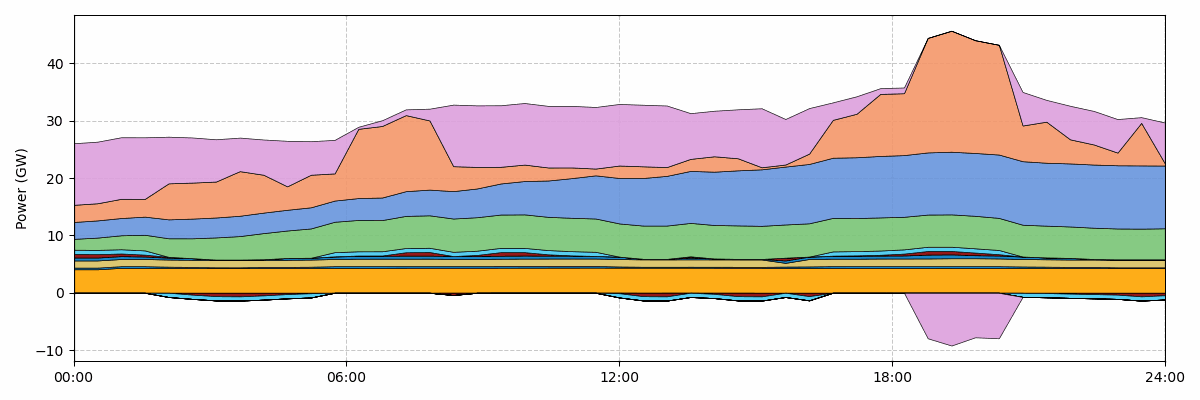

In [78]:
from IPython.display import Image, display
display(Image(filename=output_filename))

##### Consumer Payments Plot

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates


def animate_timeseries(
        df,
        column_colors,
        gif_length_sec=10,
        fps=25,
        output_filename="timeseries_animation.gif"
        ):
    """
    Creates a line plot for each column in the dataframe and animates a vertical dashed line
    moving smoothly across the plot to highlight different times of the day.

    Parameters:
      df              : pandas DataFrame with a datetime index (one day) and one or more columns.
      column_colors   : dict mapping each column name to a color (e.g., {"Series1": "blue", ...}).
      gif_length_sec  : desired total length of the gif in seconds.
      fps             : frames per second for the animation.
      output_filename : filename to save the resulting gif.
    """

    df = df.copy()
    df.index = range(0, 24)
    # Calculate total frames from gif length and fps.
    total_frames = int(gif_length_sec * fps)
    
    # Convert the first and last datetime in the index to Matplotlib date numbers.
    # x_start = mdates.date2num(df.index[0])
    # x_end = mdates.date2num(df.index[-1])
    x_start = df.index[0]
    x_end = df.index[-1]
    
    # Create an array of x positions (in date number format) for each frame.
    x_positions = np.linspace(x_start, x_end, total_frames)
    
    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(2*width_unit, height_unit))
    
    # Plot each timeseries line with its assigned color.
    for col in df.columns:
        color = column_colors.get(col, None)  # if not in dict, Matplotlib will assign a default
        ax.plot(df.index, df[col], label=nice_names[col], color=color, linewidth=2)


    
    # Format the x-axis to show ticks at 6-hour intervals in HH:MM format.
    # This uses Matplotlib's date locators and formatters.
    # ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0,6,12,18]))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    from matplotlib.ticker import LinearLocator
    ax.xaxis.set_major_locator(LinearLocator(5))

    ax.set_xticks([0, 5.75, 11.5, 17.25, 23])
    ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add axis labels, title, and a legend.
    # ax.set_xlabel("Time")
    ax.set_ylabel("Hourly Consumer Cost (m£)")
    # ax.set_title("Time Series Over One Day")
    ax.legend(
        bbox_to_anchor=(1, -0.3),
        loc='lower right',
        # borderaxespad=0.,
        # fontsize=12,
        frameon=False,
        ncol=len(df.columns) // 2,
    )
    
    # Draw an initial vertical dashed line at the leftmost time.
    # We convert the first date number back to a datetime.
    # vline = ax.axvline(x=mdates.num2date(x_positions[0]), color='k', linestyle='-', linewidth=1.5)
    vline = ax.axvline(x=x_positions[0], color='k', linestyle='-', linewidth=1.5)
    ax.set_xlim(0, 23)

    fig.tight_layout()

    # plt.show()
    # import sys
    # sys.exit()
    
    # Define the update function for the animation.
    def update(frame):
        # Convert the current x position (in date number) to a datetime.
        new_x = mdates.num2date(x_positions[frame])
        # The vertical line's x data should be a pair of identical x values (for a vertical line).
        vline.set_xdata([new_x, new_x])
        return [vline]
    
    # Create the animation.
    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True, interval=1000/fps)
    
    # Adjust layout so that labels are not cut off.
    
    # Save the animation as a gif using the pillow writer.
    ani.save(output_filename, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Animation saved as {output_filename}")


In [95]:
import pandas as pd

idx = pd.IndexSlice

df = pd.read_csv(
    f'../results/{day}/system_cost_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True,
    )

df = df.loc[df.index.get_level_values(1) != 'balancing_volume', 'national'].unstack().resample('H').sum()

out_filename = "consumer_cost_ts.gif"
animate_timeseries(
    df,
    cost_factor_colors,
    gif_length_sec=gif_length,
    fps=fps,
    output_filename=out_filename
    )

C:\Users\lukas\AppData\Local\Temp\ipykernel_2848\3885208445.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
C:\Users\lukas\AppData\Local\Temp\ipykernel_2848\3885208445.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.loc[df.index.get_level_values(1) != 'balancing_volume', 'national'].unstack().resample('H').sum()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Animation saved as consumer_cost_ts.gif


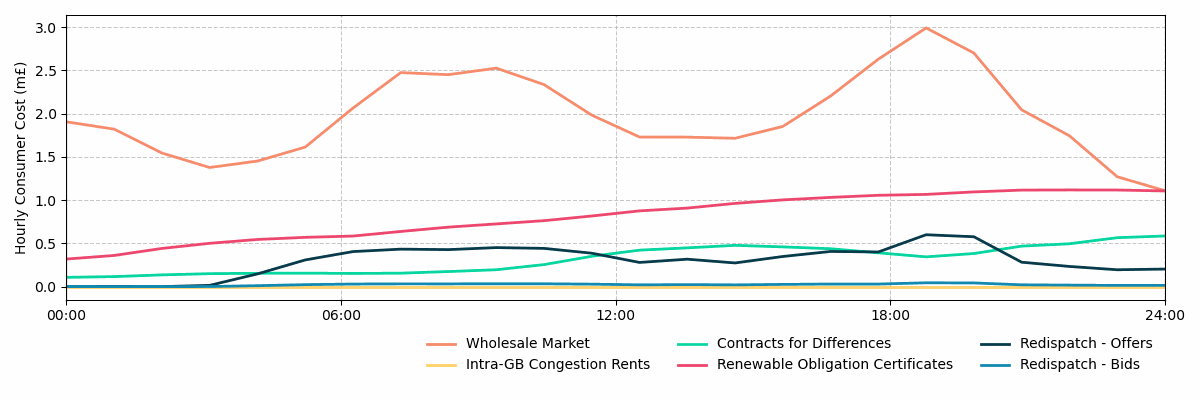

In [96]:
from IPython.display import Image, display
display(Image(filename=out_filename))

##### Dispatch on map

In [117]:
day

'2024-03-21'

In [119]:
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
    )

bmus = bmus.loc[bmus['lat'] != 'distributed']

bmus['lat'] = bmus['lat'].apply(lambda x: np.around(float(x), 4))
bmus['lon'] = bmus['lon'].apply(lambda x: np.around(float(x), 4))

n = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)
bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved_redispatch.nc'
)

# regions = gpd.read_file(Path.cwd().parent / '')

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads


In [114]:
def get_network_dispatch(n):

    d = pd.concat((
        n.generators_t.p, 
        n.links_t.p0,
        n.storage_units_t.p,
        ),
        axis=1,
        )

    mask = d.columns.str.contains('local_market')
    return d.loc[:, ~mask]

dispatch = get_network_dispatch(n)

found_locs = dispatch.columns.intersection(bmus.index)
nonfound_locs = dispatch.columns.difference(found_locs)

In [124]:
bus_locs = bal.buses.loc[bal.links.loc[nonfound_locs, 'bus1'], ['x', 'y']].rename(columns={
    'x': 'lon', 'y': 'lat'
})


In [125]:
bus_locs

,lon,lat
Bus,,
4969,0.575409,51.430896
5269,-0.032959,51.550605
4977,0.958557,51.059523
4955,0.611115,51.868012
5950,-1.572418,55.113728
4975,1.060181,51.251601
7909,-0.208961,52.960068


In [123]:
bmus

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
IBG-EGEN1,51.4600,0.6530,0.0,interconnector
IBG-ENGI1,51.4600,0.6530,0.0,interconnector
IBG-RSQ1,51.4600,0.6530,0.0,interconnector
IVD-VKL1,52.9310,-0.2210,0.0,interconnector
IVG-VKL1,52.9310,-0.2210,0.0,interconnector
...,...,...,...,...
FSDLW-1,55.7808,-5.4799,22.5,onwind
MYGPW-1,55.2488,-3.5148,25.0,onwind
OMNDO-1,54.1000,-3.4000,150.0,offwind


In [115]:
n.links.loc[nonfound_locs]

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,under_construction,ramp_rate_down,ramp_rate_up,geometry,underwater_fraction,tags,underground
BritNed,Netherlands,GB,,interconnector,0.99,True,0,inf,1045.0,0.0,...,1.0,1.0,1045.0,NaN,549.0,549.0,,NaN,,NaN
ElecLink,France,GB,,interconnector,0.99,True,0,inf,1870.0,0.0,...,1.0,1.0,1870.0,NaN,482.0,482.0,,NaN,,NaN
IFA1,France,GB,,interconnector,0.99,True,0,inf,2000.0,0.0,...,1.0,1.0,2000.0,NaN,1000.0,1000.0,,NaN,,NaN
IFA2,France,GB,,interconnector,0.99,True,0,inf,2002.0,0.0,...,1.0,1.0,2002.0,NaN,643.0,643.0,,NaN,,NaN
NSL,Norway,GB,,interconnector,0.99,True,0,inf,1400.0,0.0,...,1.0,1.0,1400.0,NaN,450.0,450.0,,NaN,,NaN
Nemo,Belgium,GB,,interconnector,0.99,True,0,inf,1024.0,0.0,...,1.0,1.0,1024.0,NaN,985.5,985.5,,NaN,,NaN
Viking,Denmark,GB,,interconnector,0.99,True,0,inf,1400.0,0.0,...,1.0,1.0,1400.0,NaN,1128.0,1128.0,,NaN,,NaN


In [113]:


dispatch.columns.difference(found_locs)

Index(['BritNed', 'ElecLink', 'IFA1', 'IFA2', 'NSL', 'Nemo', 'Viking'], dtype='object')

In [99]:
dispatch

,ABERU-1,ABRBO-1,ABRTW-1,ACHRW-1,AFTOW-1,AG-NHAV02,AIRSW-1,AKGLW-2,AKGLW-3,ANSUW-1,...,SLOY-2,SLOY-3,SLOY-4,THMRB-1,TOLLB-1,WBURB-41,WBURB-43,WHLWB-1,WISHB-1,ZEN02A
snapshot,,,,,,,,,,,,,,,,,,,,,
2024-03-21 00:00:00,0.0,46.5,9.5,4.0,7.0,-0.0,-0.0,8.0,11.0,5.0,...,0.000000,0.000000,0.0,12.25,12.25,7.500000,7.0,12.500000,12.75,5.000000
2024-03-21 00:30:00,0.0,50.5,12.5,6.0,10.0,-0.0,1.0,10.0,14.5,5.0,...,0.000000,0.000000,0.0,12.25,12.25,2.120833,0.0,12.500000,12.75,5.000000
2024-03-21 01:00:00,0.0,58.0,17.0,8.5,12.0,-0.0,1.0,14.0,20.5,5.0,...,0.000000,0.000000,0.0,12.25,4.00,0.000000,0.0,12.500000,12.75,5.000000
2024-03-21 01:30:00,0.0,76.0,22.5,11.0,16.0,-0.0,1.0,20.5,30.0,5.0,...,0.000000,0.000000,0.0,12.25,0.00,0.000000,0.0,12.083333,12.75,5.000000
2024-03-21 02:00:00,0.0,82.0,25.5,19.5,20.0,-0.0,2.0,25.5,38.0,6.0,...,0.000000,0.000000,0.0,12.25,0.00,0.000000,0.0,0.000000,-12.75,-4.191667
2024-03-21 02:30:00,0.0,83.0,29.0,21.0,23.0,-0.0,2.0,30.0,44.5,7.0,...,0.000000,0.000000,0.0,-12.25,0.00,0.000000,0.0,-12.083333,-12.75,-5.000000
2024-03-21 03:00:00,0.0,84.5,31.5,23.5,27.0,-0.0,2.0,34.0,51.0,8.0,...,0.000000,0.000000,0.0,-12.25,-12.25,-2.120833,0.0,-12.500000,-12.75,-5.000000
2024-03-21 03:30:00,0.0,85.5,32.5,26.0,31.0,-0.0,3.0,38.0,56.5,8.0,...,0.000000,0.000000,0.0,-12.25,-12.25,-7.500000,-7.0,-12.500000,-12.75,-5.000000
2024-03-21 04:00:00,0.0,86.0,26.0,38.5,34.0,-0.0,4.0,44.5,64.0,8.0,...,0.000000,0.000000,0.0,-12.25,-4.00,0.000000,0.0,-12.500000,-12.75,-5.000000
